In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy import stats
import os
import tqdm
import shap
import time
import seaborn as sns
from scipy import interp
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve,auc,roc_auc_score,confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score,brier_score_loss,precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE,RFECV
import warnings 
warnings.filterwarnings("ignore")

In [2]:
os.chdir("/Users/weiyuna/Desktop/工作/合作项目/上海胸科/20211103导出数据/房颤/补充结局-不包含瓣膜手术")

In [3]:
data_raw = pd.read_csv("AF_new_插补前.csv")

In [6]:
# data_raw = data_raw.rename(columns={"Other antiplatelet agents":"Other.antiplatelet.agents",
#                          "Antiplatelet agents":"Antiplatelet.agents",
#                         "β-blocker":"β.blocker",
#                         "Antihypertensive agents":"Antiplatelet.agents",
#                         "Ever smoking":"Ever.smoking",
#                         "Ever drinking":"Ever.drinking",
#                         "Heart failure":"Heart.failure",
#                         "Prior RFA":"Prior.RFA",
#                         "Prior PCI":"Prior.PCI",
#                         "Prior CABG":"Prior.CABG"})

In [7]:
# data_raw[["AF_category"]].isnull()

In [4]:
data = pd.read_csv("data_imputation_full.csv")

In [5]:
data["TnI"].describe()

count    3365.000000
mean        0.020018
std         0.254157
min         0.000000
25%         0.000000
50%         0.000000
75%         0.010000
max        13.020000
Name: TnI, dtype: float64

In [6]:
data.loc[data.outcome==1,"TnI"].describe()

count    62.000000
mean      0.108065
std       0.572635
min       0.000000
25%       0.000000
50%       0.010000
75%       0.020000
max       4.300000
Name: TnI, dtype: float64

In [7]:
data.loc[data.outcome==0,"TnI"].describe()

count    3303.000000
mean        0.018365
std         0.244137
min         0.000000
25%         0.000000
50%         0.000000
75%         0.010000
max        13.020000
Name: TnI, dtype: float64

In [8]:
features_outcome = data.columns[2:5]

In [9]:
features_include = data.columns[5:65]

In [10]:
X = data_raw[features_include]
Y = data_raw[features_outcome]

In [11]:
## 随机拆分训练集和验证集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=123)

In [12]:
Y1_train = Y_train["outcome"]
Y2_train = Y_train["outcome_h"]
Y3_train = Y_train["outcome_b"]
Y1_test = Y_test["outcome"]
Y2_test = Y_test["outcome_h"]
Y3_test = Y_test["outcome_b"]

In [14]:
Y1_test.value_counts()

0    991
1     19
Name: outcome, dtype: int64

In [27]:
Y1_train.index

Int64Index([1892, 1671, 1688, 2581, 2221, 3125, 2311,  393, 1420, 2529,
            ...
              96, 1761, 3286, 1593, 1147, 2154, 3089, 1766, 1122, 1346],
           dtype='int64', length=2355)

In [33]:
data_raw[outcome_rf_feature[0:15]].iloc[Y1_train.index,].dropna()

,Ccr,ALB,CHA2DS2_VACS,DD,AST,NT_proBNP,LDH,TSH,CREA,Age,TT,FBG,TnI,UA,GLU
1671,37.51,42.0,5.0,0.35,27.0,3820.0,180.0,2.95,89.0,77,18.5,2.37,0.03,509.0,4.6
1688,107.50,41.0,4.0,0.23,24.0,1530.0,259.0,3.30,58.0,65,18.8,3.10,0.00,349.0,9.9
2221,102.37,45.0,2.0,0.19,19.0,1620.0,219.0,0.88,68.0,67,17.4,3.42,0.00,282.0,7.7
3125,41.23,43.0,2.0,0.49,28.0,596.0,152.0,3.62,106.0,75,17.6,1.96,0.01,423.0,5.1
2311,62.58,38.0,5.0,0.37,27.0,2210.0,181.0,3.33,70.0,78,17.5,4.73,0.01,439.0,6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3286,61.49,46.0,2.0,0.19,21.0,51.0,212.0,1.34,119.0,67,17.0,2.86,0.00,395.0,6.8
1147,91.84,50.0,2.0,0.19,25.0,329.0,202.0,1.25,82.0,63,18.8,2.38,0.00,366.0,5.2
2154,63.94,42.0,5.0,0.20,11.0,906.0,174.0,3.39,87.0,75,17.5,3.15,0.00,333.0,7.4
3089,47.46,39.0,3.0,0.49,19.0,3950.0,362.0,1.84,102.0,74,19.1,2.36,0.01,440.0,6.9


In [205]:
def cut_off_select_by_Youden(include_feature_list,feature_out,model):
    x = data[include_feature_list]
    y = data.loc[x.index,feature_out]
    best_thresh_list = []
    
    rskf = RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=1234)
    for train_index, test_index in rskf.split(x,y):   
    #     print("train:",train_index,"test:",test_index)
        x_train,x_test = x.loc[train_index],x.loc[test_index]
        y_train,y_test = y[train_index],y[test_index]           
        model = model
        model.fit(x_train,y_train) 
        
        true_Y = y_test
        predictY = model.predict_proba(x_test)[:,1]
        thresh_list = []
        sensitivity_list = []
        specificity_list = []
        Youden_list = []
        ## 根据最大化Youden指数对应的threshold
        for thresh in np.arange(0,1,0.02):
            predict_Y = [1 if x > thresh else 0 for x in predictY]
            fpr, tpr, thresholds = metrics.roc_curve(true_Y, predict_Y, pos_label=1)
            sensitivity = recall_score(true_Y, predict_Y)
            tn, fp, fn, tp = confusion_matrix(true_Y, predict_Y).ravel()
            specificity = tn / (tn+fp)
            npv = tn / (tn + fn)
            Youden = sensitivity + specificity - 1
            thresh_list.append(thresh)
            sensitivity_list.append(sensitivity)
            specificity_list.append(specificity)
            Youden_list.append(Youden)
#         print(Youden_list)   
#         best_Youden = np.max(Youden_list)
        best_Youden_index = Youden_list.index(np.max(Youden_list))
        max_Youde_thresh = thresh_list[best_Youden_index]
        best_thresh_list.append(max_Youde_thresh)
    thresh = round(np.mean(best_thresh_list),3)
    return thresh

In [253]:
model_name_list = [dt1,dt2,dt3]
outcome_list = ["outcome","outcome_h","outcome_b"]
for i in range(0,3):
    model = model_name_list[i]
    outcome = outcome_list[i] 
    thresh = cut_off_select_by_Youden(features_include,outcome,model)
    print(outcome,thresh)

outcome 0.396
outcome_h 0.45
outcome_b 0.39


In [254]:
model_name_list = [rf1,rf2,rf3]
outcome_list = ["outcome","outcome_h","outcome_b"]
for i in range(0,3):
    model = model_name_list[i]
    outcome = outcome_list[i] 
    thresh = cut_off_select_by_Youden(features_include,outcome,model)
    print(outcome,thresh)

outcome 0.026
outcome_h 0.024
outcome_b 0.022


In [255]:
model_name_list = [gbm1,gbm2,gbm3]
outcome_list = ["outcome","outcome_h","outcome_b"]
for i in range(0,3):
    model = model_name_list[i]
    outcome = outcome_list[i] 
    thresh = cut_off_select_by_Youden(features_include,outcome,model)
    print(outcome,thresh)

outcome 0.026
outcome_h 0.014
outcome_b 0.071


In [256]:
model_name_list = [xgb1,xgb2,xgb3]
outcome_list = ["outcome","outcome_h","outcome_b"]
for i in range(0,3):
    model = model_name_list[i]
    outcome = outcome_list[i] 
    thresh = cut_off_select_by_Youden(features_include,outcome,model)
    print(outcome,thresh)

outcome 0.147
outcome_h 0.008
outcome_b 0.022


In [206]:
model_name_list = [dt1,dt2,dt3]
outcome_list = ["outcome","outcome_h","outcome_b"]
feature_list = [outcome_dt_feature,outcome_h_dt_feature,outcome_b_dt_feature]

for i in range(0,3):
    model = model_name_list[i]
    outcome = outcome_list[i]
    features = feature_list[i]
    for n in [5,10,15,20]:
        thresh = cut_off_select_by_Youden(features[0:n],outcome,model)
        print(outcome,n,thresh) 

outcome 5 0.374
outcome 10 0.506
outcome 15 0.533
outcome 20 0.416
outcome_h 5 0.434
outcome_h 10 0.445
outcome_h 15 0.434
outcome_h 20 0.438
outcome_b 5 0.248
outcome_b 10 0.434
outcome_b 15 0.392
outcome_b 20 0.54


In [207]:
model_name_list = [rf1,rf2,rf3]
outcome_list = ["outcome","outcome_h","outcome_b"]
feature_list = [outcome_rf_feature,outcome_h_rf_feature,outcome_b_rf_feature]

for i in range(0,3):
    model = model_name_list[i]
    outcome = outcome_list[i]
    features = feature_list[i]
    for n in [5,10,15,20]:
        thresh = cut_off_select_by_Youden(features[0:n],outcome,model)
        print(outcome,n,thresh) 

outcome 5 0.03
outcome 10 0.04
outcome 15 0.032
outcome 20 0.029
outcome_h 5 0.028
outcome_h 10 0.031
outcome_h 15 0.024
outcome_h 20 0.023
outcome_b 5 0.024
outcome_b 10 0.022
outcome_b 15 0.022
outcome_b 20 0.023


In [208]:
model_name_list = [gbm1,gbm2,gbm3]
outcome_list = ["outcome","outcome_h","outcome_b"]
feature_list = [outcome_gbm_feature,outcome_h_gbm_feature,outcome_b_gbm_feature]

for i in range(0,3):
    model = model_name_list[i]
    outcome = outcome_list[i]
    features = feature_list[i]
    for n in [5,10,15,20]:
        thresh = cut_off_select_by_Youden(features[0:n],outcome,model)
        print(outcome,n,thresh) 

outcome 5 0.022
outcome 10 0.022
outcome 15 0.025
outcome 20 0.028
outcome_h 5 0.037
outcome_h 10 0.035
outcome_h 15 0.016
outcome_h 20 0.016
outcome_b 5 0.05
outcome_b 10 0.046
outcome_b 15 0.072
outcome_b 20 0.074


In [178]:
# model_name_list = [xgb1,xgb2,xgb3]
# outcome_list = ["outcome","outcome_h","outcome_b"]
# feature_list = [outcome_xgb_feature,outcome_h_xgb_feature,outcome_b_xgb_feature]
# for i in range(0,3):
#     model = model_name_list[i]
#     outcome = outcome_list[i]
#     features = feature_list[i]
#     for n in [5,10,15,20]:
#         thresh = cut_off_select_by_Youden(features[0:n],outcome,model)
#         print(outcome,n,thresh) 

outcome 5 0.14
outcome 10 0.14
outcome 15 0.14
outcome 20 0.14
outcome_h 5 0.023
outcome_h 10 0.041
outcome_h 15 0.031
outcome_h 20 0.034
outcome_b 5 0.02
outcome_b 10 0.02
outcome_b 15 0.02
outcome_b 20 0.02


In [449]:
def cut_off_select_by_F1(include_feature_list,feature_out,model):
    x = data[include_feature_list]
    y = data.loc[x.index,feature_out]
    best_thresh_list = []
    
    rskf = RepeatedStratifiedKFold(n_repeats=20, n_splits=5, random_state=1234)
    for train_index, test_index in rskf.split(x,y):   
    #     print("train:",train_index,"test:",test_index)
        x_train,x_test = x.loc[train_index],x.loc[test_index]
        y_train,y_test = y[train_index],y[test_index]           
        model = model
        model.fit(x_train,y_train)      
        
        ## 根据最大化F1_score对应的threshold
        precision,recall,thresholds = precision_recall_curve(y_test,model.predict_proba(x_test)[:,1])
#         print(len(np.unique(model.predict_proba(x_train)[:,1])))
#         print(precision,recall,thresholds)
        f1_score = (2 * recall * precision)/(precision + recall)   
        best_f1_score = np.max(f1_score[np.isfinite(f1_score)])
        best_f1_score_index = np.argmax(f1_score[np.isfinite(f1_score)])  
        max_f1_thresh = thresholds[best_f1_score_index]
#         print(f1_score,best_f1_score,best_f1_score_index)
        best_thresh_list.append(max_f1_thresh)
#         print(best_thresh_list)
    thresh = round(np.median(best_thresh_list),3)
    return thresh

In [476]:
cut_off_select_by_F1(outcome_rf_feature[0:5],"outcome",rf1)

0.104

In [17]:
def repeated_kfold_eval(model,features,outcome,n,thresh):
    rd = [11,22,33,44,55,66,77,88,99,123,234,345,456,567,678,789,1234,2345,3456,4567]
    res_model = []
    predict_all = []
    true_all = []

    x = data[features]
    y = data.loc[x.index,outcome]

    for rs in rd:
        kfold = StratifiedKFold(n_splits=n, random_state=rs, shuffle=True)
        trueY_full = []
        predictY_full = []
        for train_idx, test_idx in kfold.split(x, y):
        #     print(len(train_idx), len(test_idx), sum(Y[train_idx]))
            x_train,x_test = x.loc[train_idx],x.loc[test_idx]
            y_train,y_test = y[train_idx],y[test_idx]  
        #         param_classifier.update({'scale_pos_weight': (sum(y_train==0))/sum(y_train)})
        #         param_classifier.update({'scale_pos_weight': 30})
            model = model
            model.fit(x_train,y_train)
            trueY = list(y_test)
            trueY_full.extend(trueY)
    #         predicted_output = model.predict(x_test, iteration_range=(0, model.best_iteration))
            predicted_output = model.predict_proba(x_test)[:, 1]
            predictY_full.extend(list(predicted_output))

        trueY = trueY_full
        res = {}
        predict_all.append(predictY_full)
        true_all.append(trueY_full)
        thred = thresh
        predY = [1 if x > thred else 0 for x in predictY_full]
        fpr, tpr, thresholds = metrics.roc_curve(trueY, predictY_full, pos_label=1)
        auc = metrics.auc(fpr, tpr)
        tn, fp, fn, tp = confusion_matrix(trueY, predY).ravel()
        specificity = tn / (tn+fp)
        npv = tn / (tn + fn)

        res.update({
        #         'model': model,
            'ACC': accuracy_score(trueY, predY),
            'AUC': auc,
            'Sensitivity(recall)': recall_score(trueY, predY),
            'Specificity': specificity,
            'PPV(precision)': precision_score(trueY, predY),
            'NPV': npv,
            'F score': f1_score(trueY, predY),
            'Youden':recall_score(trueY, predY)+specificity-1,
            'Brier score': brier_score_loss(trueY, predY)
        })
        res_model.append(res)
    return pd.DataFrame(res_model)

# Decision Tree

## 复合结局

In [150]:
# 复合结局参数的最佳取值：: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 50, 'random_state': 123}
# 最佳模型得分: 0.6553630243513512
dt1 = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=5,max_features=3, 
                             min_samples_leaf=2,min_samples_split=50,random_state=123)

In [151]:
outcome_dt_feature = ['DBP', 'Ccr', 'LVEDD', 'HAS_BLED', 'AST', 'DD', 'CKD', 'NT_proBNP','PTINR', 'CREA', 
                    'COPD', 'FBG', 'Antihypertensive.agents','Ever.smoking', 'AF_category', 'Ever.drinking', 
                    'Diuretics','β.blocker', 'ACEI_ARB', 'Statins']

In [152]:
res_dt_top5 = repeated_kfold_eval(dt1,outcome_dt_feature[0:5],"outcome",5,0.374) ##0.726

In [154]:
res_dt_top5.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.599480,0.626995,0.615323,0.599183,0.028107,0.988101,0.053742,0.214505,0.400520
std,0.032159,0.029342,0.056184,0.033210,0.002779,0.001499,0.005194,0.051278,0.032159
min,0.559881,0.568625,0.451613,0.557675,0.024221,0.984608,0.045977,0.110105,0.320654
25%,0.579866,0.603880,0.596774,0.579246,0.025972,0.987059,0.049754,0.175394,0.386181
50%,0.587519,0.620157,0.612903,0.587193,0.028057,0.988415,0.053881,0.235644,0.412481
75%,0.613819,0.648250,0.661290,0.612701,0.029373,0.989200,0.056108,0.239896,0.420134
max,0.679346,0.672085,0.693548,0.680291,0.035616,0.990631,0.067416,0.309323,0.440119


In [155]:
res_dt_top10 = repeated_kfold_eval(dt1,outcome_dt_feature[0:10],"outcome",5,0.506)

In [156]:
res_dt_top10.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.755617,0.603137,0.464516,0.761081,0.035154,0.986983,0.065338,0.225597,0.244383
std,0.016960,0.040262,0.073746,0.018021,0.004604,0.001613,0.008605,0.065299,0.016960
min,0.721545,0.521537,0.306452,0.725098,0.026874,0.983822,0.049415,0.098156,0.215156
25%,0.744725,0.576115,0.403226,0.749849,0.033082,0.985939,0.061232,0.188724,0.236924
50%,0.757355,0.618053,0.475806,0.763094,0.034916,0.987140,0.065334,0.231029,0.242645
75%,0.763076,0.627561,0.532258,0.769679,0.038278,0.988365,0.071594,0.288788,0.255275
max,0.784844,0.655201,0.564516,0.791705,0.042818,0.989226,0.078880,0.315046,0.278455


In [157]:
res_dt_top15 = repeated_kfold_eval(dt1,outcome_dt_feature[0:15],"outcome",5,0.533)

In [158]:
res_dt_top15.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.739108,0.586293,0.409677,0.745292,0.029893,0.985354,0.055556,0.154970,0.260892
std,0.049869,0.030986,0.072396,0.051594,0.005205,0.001472,0.009095,0.059185,0.049869
min,0.657355,0.536506,0.274194,0.661823,0.021719,0.982955,0.041131,0.055853,0.153938
25%,0.704086,0.558690,0.354839,0.708371,0.026285,0.984655,0.048965,0.119077,0.222883
50%,0.745171,0.587778,0.411290,0.750984,0.030041,0.985015,0.055644,0.143254,0.254829
75%,0.777117,0.616431,0.455645,0.785044,0.032566,0.986229,0.060958,0.197499,0.295914
max,0.846062,0.628151,0.564516,0.855586,0.042169,0.988215,0.075000,0.249954,0.342645


In [159]:
res_dt_top20 = repeated_kfold_eval(dt1,outcome_dt_feature[0:20],"outcome",5,0.416)

In [160]:
res_dt_top20.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.429480,0.567415,0.662903,0.425098,0.021191,0.985521,0.041048,0.088002,0.570520
std,0.075497,0.037525,0.104646,0.078514,0.002078,0.002543,0.004019,0.060521,0.075497
min,0.248440,0.452575,0.370968,0.237663,0.014128,0.977547,0.027219,-0.114954,0.472511
25%,0.382169,0.556085,0.608871,0.375568,0.020417,0.984613,0.039500,0.062386,0.517533
50%,0.447103,0.572944,0.653226,0.442325,0.021479,0.985687,0.041737,0.097905,0.552897
75%,0.482467,0.586702,0.745968,0.479488,0.022331,0.986611,0.043019,0.116472,0.617831
max,0.527489,0.624413,0.822581,0.526794,0.024326,0.989482,0.047107,0.183352,0.751560


In [257]:
res_dt_all = repeated_kfold_eval(dt1,features_include,"outcome",5,0.396)

In [258]:
res_dt_all.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.620654,0.579606,0.554839,0.621889,0.027198,0.986743,0.051777,0.176728,0.379346
std,0.073814,0.035350,0.090849,0.076276,0.004076,0.002034,0.007556,0.072308,0.073814
min,0.447845,0.511021,0.354839,0.444444,0.020811,0.983687,0.040289,0.073477,0.276672
25%,0.593908,0.553681,0.495968,0.594384,0.023969,0.984677,0.045279,0.109252,0.327786
50%,0.631501,0.581307,0.564516,0.631698,0.027677,0.986958,0.052645,0.181062,0.368499
75%,0.672214,0.605849,0.629032,0.676809,0.029591,0.988684,0.056489,0.241835,0.406092
max,0.723328,0.641260,0.677419,0.730245,0.035605,0.989540,0.066986,0.277504,0.552155


## 心包积液结局

In [29]:
# 心包积液参数的最佳取值：: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'max_features': 15, 'min_samples_leaf': 50, 'min_samples_split': 2, 'random_state': 123}
# 最佳模型得分: 0.6590061926190903
dt2 = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=3,
                             min_samples_leaf=50,min_samples_split=2,random_state=123)

In [30]:
outcome_h_dt_feature = ['HAS_BLED', 'AST', 'LVEDD', 'AF_category', 'Ever.drinking','Dabigatran', 'Rivaroxaban', 
                      'Heparin', 'Anticoagulants','Statins', 'ACEI_ARB', 'β.blocker', 'Diuretics', 'CCB',
                      'Antihypertensive.agents', 'Ever.smoking', 'Heart.failure','Angina', 'Antiplatelet.agents',
                      'Stroke']

In [31]:
res2_dt_top5 = repeated_kfold_eval(dt2,outcome_h_dt_feature[0:5],"outcome_h",5,0.434) #0.52

In [32]:
res2_dt_top5.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.428722,0.606086,0.710714,0.426356,0.010334,0.994356,0.020368,0.137070,0.571278
std,0.064779,0.035794,0.081028,0.065763,0.000980,0.001251,0.001915,0.062938,0.064779
min,0.309361,0.533494,0.535714,0.305664,0.008246,0.991591,0.016243,-0.004891,0.452897
25%,0.378009,0.581014,0.669643,0.374213,0.009975,0.993809,0.019667,0.117928,0.531352
50%,0.419168,0.611785,0.732143,0.416392,0.010462,0.994426,0.020584,0.139368,0.580832
75%,0.468648,0.626358,0.758929,0.467785,0.010821,0.995032,0.021336,0.173068,0.621991
max,0.547103,0.672894,0.857143,0.546299,0.012386,0.996820,0.024328,0.232929,0.690639


In [33]:
res2_dt_top10 = repeated_kfold_eval(dt2,outcome_h_dt_feature[0:10],"outcome_h",5,0.445)

In [34]:
res2_dt_top10.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.737831,0.602394,0.423214,0.740470,0.014093,0.993486,0.027221,0.163685,0.262169
std,0.070697,0.039713,0.067837,0.071614,0.002889,0.000685,0.005418,0.064633,0.070697
min,0.589004,0.531647,0.285714,0.590351,0.008702,0.991944,0.017058,0.018922,0.162259
25%,0.686478,0.568968,0.392857,0.688043,0.011550,0.992950,0.022446,0.118937,0.200297
50%,0.751263,0.602669,0.428571,0.754420,0.014023,0.993596,0.027245,0.177870,0.248737
75%,0.799703,0.620846,0.464286,0.803491,0.015912,0.994052,0.030798,0.218243,0.313522
max,0.837741,0.683933,0.535714,0.842373,0.018898,0.994370,0.036199,0.245826,0.410996


In [35]:
res2_dt_top15 = repeated_kfold_eval(dt2,outcome_h_dt_feature[0:15],"outcome_h",5,0.434)

In [36]:
res2_dt_top15.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.789346,0.598290,0.378571,0.792793,0.015358,0.993470,0.029474,0.171364,0.210654
std,0.046210,0.044808,0.070862,0.046970,0.002495,0.000570,0.004711,0.055090,0.046210
min,0.668945,0.493471,0.250000,0.670662,0.011691,0.992658,0.022807,0.096023,0.132541
25%,0.772065,0.568998,0.312500,0.774723,0.012878,0.992935,0.024679,0.126726,0.187147
50%,0.804458,0.596373,0.392857,0.808211,0.015581,0.993457,0.029452,0.176142,0.195542
75%,0.812853,0.624774,0.428571,0.817126,0.017434,0.993793,0.033442,0.208560,0.227935
max,0.867459,0.684040,0.464286,0.872640,0.019174,0.994418,0.036827,0.265005,0.331055


In [37]:
res2_dt_top20 = repeated_kfold_eval(dt2,outcome_h_dt_feature[0:20],"outcome_h",5,0.438)

In [38]:
res2_dt_top20.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.789272,0.595643,0.371429,0.792778,0.015038,0.993397,0.028864,0.164207,0.210728
std,0.045458,0.047596,0.077210,0.046232,0.002654,0.000640,0.005030,0.061183,0.045458
min,0.668945,0.493471,0.250000,0.670662,0.010479,0.992214,0.020115,0.051918,0.132541
25%,0.775186,0.570122,0.285714,0.777794,0.012719,0.992881,0.024492,0.121243,0.187147
50%,0.801932,0.595333,0.392857,0.806113,0.015403,0.993395,0.029130,0.155342,0.198068
75%,0.812853,0.624774,0.437500,0.817126,0.017364,0.993793,0.033258,0.208560,0.224814
max,0.867459,0.684040,0.464286,0.872640,0.019174,0.994418,0.036827,0.265005,0.331055


In [259]:
res2_dt_all = repeated_kfold_eval(dt2,features_include,"outcome_h",5,0.45)

In [260]:
res2_dt_all.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.590951,0.513331,0.405357,0.592508,0.008243,0.991664,0.016148,-0.002135,0.409049
std,0.063326,0.044491,0.101198,0.064478,0.001347,0.001008,0.002653,0.069384,0.063326
min,0.489153,0.440317,0.250000,0.488762,0.005450,0.989457,0.010695,-0.151804,0.277563
25%,0.542793,0.476351,0.348214,0.543527,0.007596,0.991225,0.014795,-0.031155,0.364116
50%,0.569985,0.516276,0.375000,0.570423,0.008082,0.991572,0.015764,-0.008958,0.430015
75%,0.635884,0.536522,0.473214,0.638672,0.009032,0.992249,0.017730,0.038481,0.457207
max,0.722437,0.639711,0.607143,0.726401,0.011716,0.994253,0.022989,0.177416,0.510847


## 出血结局

In [39]:
# 出血参数的最佳取值：: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 30, 'random_state': 123}
# 最佳模型得分: 0.828451348133327
dt3 = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,max_features=3, 
                             min_samples_leaf=10,min_samples_split=30,random_state=123)

In [40]:
outcome_b_dt_feature = ['Ccr', 'LVEDD', 'PTINR', 'HAS_BLED', 'DD', 'CREA', 'NT_proBNP','DBP', 'FBG', 'COPD', 
                      'ALB', 'Ever.drinking', 'Ever.smoking','AF_category', 'Angina', 'CCB', 'Diuretics', 
                      'β.blocker','ACEI_ARB', 'Statins']

In [41]:
res3_dt_top5 = repeated_kfold_eval(dt3,outcome_b_dt_feature[0:5],"outcome_b",5,0.248) # 0.65

In [42]:
res3_dt_top5.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.806508,0.648751,0.470370,0.809227,0.019448,0.994746,0.037341,0.279597,0.193492
std,0.015950,0.040923,0.088384,0.016640,0.002509,0.000793,0.004883,0.075871,0.015950
min,0.776820,0.579295,0.333333,0.778610,0.015177,0.993506,0.029032,0.158378,0.162259
25%,0.797325,0.621954,0.398148,0.799506,0.017711,0.994133,0.034002,0.222968,0.180981
50%,0.807875,0.646964,0.481481,0.810365,0.019221,0.994814,0.037010,0.286305,0.192125
75%,0.819019,0.678665,0.527778,0.822573,0.021292,0.995270,0.041012,0.331328,0.202675
max,0.837741,0.730422,0.666667,0.841821,0.024096,0.996562,0.046512,0.448272,0.223180


In [43]:
res3_dt_top10 = repeated_kfold_eval(dt3,outcome_b_dt_feature[0:10],"outcome_b",5,0.434)

In [44]:
res3_dt_top10.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.832541,0.636200,0.438889,0.835725,0.021122,0.994610,0.040276,0.274614,0.167459
std,0.021306,0.056050,0.104946,0.021942,0.004141,0.000933,0.007915,0.094432,0.021306
min,0.793462,0.502397,0.259259,0.795686,0.013616,0.993094,0.026163,0.120853,0.132244
25%,0.819019,0.605311,0.333333,0.821525,0.018406,0.993830,0.034926,0.200311,0.151486
50%,0.834770,0.646720,0.444444,0.838077,0.020910,0.994729,0.040009,0.292557,0.165230
75%,0.848514,0.673692,0.518519,0.852082,0.023332,0.995330,0.044668,0.346690,0.180981
max,0.867756,0.742261,0.592593,0.872079,0.027344,0.996020,0.051948,0.417338,0.206538


In [45]:
res3_dt_top15 = repeated_kfold_eval(dt3,outcome_b_dt_feature[0:15],"outcome_b",5,0.392)

In [46]:
res3_dt_top15.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.770074,0.638519,0.483333,0.772394,0.016940,0.994631,0.032714,0.255727,0.229926
std,0.029592,0.041873,0.094216,0.030230,0.002744,0.000891,0.005282,0.082222,0.029592
min,0.712036,0.554152,0.333333,0.713901,0.011613,0.993050,0.022444,0.103855,0.178603
25%,0.753343,0.618455,0.435185,0.754494,0.015100,0.994080,0.029264,0.195407,0.206835
50%,0.766270,0.632126,0.481481,0.769473,0.017024,0.994578,0.032991,0.252807,0.233730
75%,0.793165,0.665665,0.555556,0.795536,0.018806,0.995292,0.036199,0.308673,0.246657
max,0.821397,0.716275,0.666667,0.825045,0.021834,0.996340,0.042017,0.400639,0.287964


In [49]:
res3_dt_top20 = repeated_kfold_eval(dt3,outcome_b_dt_feature[0:20],"outcome_b",5,0.54)

In [50]:
res3_dt_top20.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.837266,0.622776,0.379630,0.840968,0.018889,0.994080,0.035954,0.220597,0.162734
std,0.022739,0.039333,0.097529,0.023413,0.003645,0.000840,0.006976,0.084722,0.022739
min,0.793165,0.571589,0.222222,0.795686,0.011407,0.992603,0.021700,0.066440,0.126300
25%,0.827860,0.589053,0.324074,0.831411,0.016167,0.993543,0.030954,0.166570,0.146508
50%,0.839376,0.622606,0.370370,0.843170,0.019014,0.994046,0.036146,0.214233,0.160624
75%,0.853492,0.658302,0.425926,0.857849,0.020923,0.994537,0.039811,0.270593,0.172140
max,0.873700,0.690322,0.555556,0.878370,0.025878,0.995614,0.049296,0.371613,0.206835


In [261]:
res3_dt_all = repeated_kfold_eval(dt3,features_include,"outcome_b",5,0.39)

In [263]:
res3_dt_all.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.758128,0.620018,0.468519,0.760470,0.015860,0.994366,0.030666,0.228989,0.241872
std,0.029670,0.050811,0.091731,0.029775,0.004168,0.001008,0.007960,0.101131,0.029670
min,0.690936,0.555983,0.259259,0.693229,0.009736,0.992441,0.018767,0.045958,0.188113
25%,0.739450,0.586826,0.407407,0.741612,0.013238,0.993686,0.025643,0.161751,0.218871
50%,0.756612,0.606470,0.462963,0.758987,0.014800,0.994206,0.028745,0.214666,0.243388
75%,0.781129,0.647961,0.527778,0.782804,0.017495,0.995085,0.033885,0.298094,0.260550
max,0.811887,0.730583,0.629630,0.813361,0.026562,0.996330,0.050975,0.442991,0.309064


# SVM

In [61]:
# 复合结局参数的最佳取值：: {'C': 0.001, 'class_weight': 'balanced', 'kernel': 'linear', 'random_state': 123}
# 最佳模型得分: 0.6361143396162852
# svm1 = svm.SVC(C =0.001, class_weight = 'balanced',kernel = 'linear',random_state=123,probability=True)

In [ ]:
# 心包积液参数的最佳取值：: {'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf', 'random_state': 123}
# 最佳模型得分: 0.6966970690253126
# svm2 = svm.SVC(C =0.1, class_weight = 'balanced',kernel = 'rbf',random_state=123,probability=True)

In [ ]:
# 出血参数的最佳取值：: {'C': 0.05, 'class_weight': 'balanced', 'kernel': 'linear', 'random_state': 123}
# 最佳模型得分: 0.703027056847293
# svm3 = svm.SVC(C =0.05, class_weight = 'balanced',kernel = 'linear',random_state=123,probability=True)

# Random Forest

## 复合结局

In [16]:
# 复合结局参数的最佳取值：: {'criterion': 'gini', 'max_depth': 7, 'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 50, 'n_estimators': 100, 'random_state': 123}
# 最佳模型得分: 0.7341498363288247
rf1 = RandomForestClassifier(criterion='gini',max_depth=7,max_features=5,min_samples_leaf=5,min_samples_split=50,
                           n_estimators=100,random_state=123)

In [17]:
outcome_rf_feature = ['Ccr', 'ALB', 'CHA2DS2_VACS', 'DD', 'AST', 'NT_proBNP', 'LDH','TSH', 'CREA', 'Age', 
                      'TT', 'FBG', 'TnI', 'UA', 'GLU', 'HR', 'CK','DBP', 'LVEF', 'LAD']

In [18]:
outcome_rf_feature[0:5]

['Ccr', 'ALB', 'CHA2DS2_VACS', 'DD', 'AST']

In [54]:
res_rf_top5 = repeated_kfold_eval(rf1,outcome_rf_feature[0:5],"outcome",5,0.03) 

In [55]:
res_rf_top5.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.805275,0.676584,0.365323,0.813533,0.035482,0.985567,0.064679,0.178856,0.194725
std,0.004267,0.013606,0.027826,0.004303,0.002731,0.000631,0.004958,0.028263,0.004267
min,0.796434,0.649786,0.322581,0.805328,0.030166,0.984456,0.055172,0.127909,0.189004
25%,0.802303,0.670237,0.338710,0.810248,0.033518,0.985072,0.061095,0.157814,0.191382
50%,0.806092,0.676745,0.370968,0.814260,0.036135,0.985706,0.065856,0.185228,0.193908
75%,0.808618,0.687037,0.387097,0.816909,0.037085,0.986008,0.067557,0.197875,0.197697
max,0.810996,0.699237,0.403226,0.819861,0.039809,0.986482,0.072464,0.220664,0.203566


In [56]:
res_rf_top10 = repeated_kfold_eval(rf1,outcome_rf_feature[0:10],"outcome",5,0.04)

In [57]:
res_rf_top10.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.865423,0.699289,0.297581,0.876082,0.043198,0.985172,0.075435,0.173663,0.134577
std,0.004583,0.015612,0.023093,0.004543,0.003891,0.000504,0.006626,0.024611,0.004583
min,0.858247,0.659723,0.258065,0.868907,0.036364,0.984274,0.063745,0.129696,0.126895
25%,0.861887,0.691927,0.286290,0.872540,0.039887,0.984846,0.070014,0.156938,0.131055
50%,0.864487,0.701628,0.298387,0.875265,0.043385,0.985205,0.076003,0.175317,0.135513
75%,0.868945,0.706737,0.306452,0.879503,0.045559,0.985414,0.079333,0.185955,0.138113
max,0.873105,0.731349,0.338710,0.883137,0.051597,0.986139,0.089552,0.221846,0.141753


In [58]:
res_rf_top15 = repeated_kfold_eval(rf1,outcome_rf_feature[0:15],"outcome",5,0.032)

In [59]:
res_rf_top15.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.835438,0.694985,0.387097,0.843854,0.044513,0.986549,0.079840,0.230951,0.164562
std,0.004575,0.013017,0.026683,0.004460,0.003526,0.000607,0.006213,0.028569,0.004575
min,0.827340,0.668820,0.322581,0.835301,0.035842,0.985037,0.064516,0.159698,0.156315
25%,0.832244,0.684092,0.370968,0.840372,0.043420,0.986265,0.077825,0.218833,0.161813
50%,0.836701,0.697777,0.387097,0.844838,0.044273,0.986561,0.079620,0.231632,0.163299
75%,0.838187,0.704108,0.403226,0.847184,0.046972,0.986938,0.084142,0.249653,0.167756
max,0.843685,0.714780,0.419355,0.851650,0.050388,0.987364,0.089965,0.271005,0.172660


In [60]:
res_rf_top20 = repeated_kfold_eval(rf1,outcome_rf_feature[0:20],"outcome",5,0.029)

In [61]:
res_rf_top20.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.833522,0.721021,0.460484,0.840524,0.051411,0.988096,0.092488,0.301008,0.166478
std,0.004271,0.016727,0.030725,0.004523,0.003055,0.000650,0.005511,0.029427,0.004271
min,0.827637,0.701860,0.403226,0.833787,0.044484,0.986800,0.080128,0.240646,0.159287
25%,0.829643,0.705483,0.435484,0.836815,0.048726,0.987632,0.087882,0.281684,0.163299
50%,0.833878,0.717071,0.467742,0.841054,0.052357,0.988248,0.094160,0.307887,0.166122
75%,0.836701,0.731382,0.483871,0.843854,0.053344,0.988555,0.095925,0.320686,0.170357
max,0.840713,0.755501,0.500000,0.848320,0.056673,0.988999,0.101806,0.343778,0.172363


In [264]:
res_rf_all = repeated_kfold_eval(rf1,features_include,"outcome",5,0.026)

In [265]:
res_rf_all.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.804695,0.707930,0.513710,0.810157,0.048351,0.988859,0.088381,0.323867,0.195305
std,0.004089,0.011838,0.029729,0.004116,0.002844,0.000678,0.005168,0.030105,0.004089
min,0.795542,0.683201,0.467742,0.801393,0.042398,0.987691,0.077748,0.269437,0.190788
25%,0.803269,0.701171,0.495968,0.808432,0.047271,0.988488,0.086314,0.308335,0.192496
50%,0.806538,0.710571,0.516129,0.812140,0.048478,0.988938,0.088745,0.328118,0.193462
75%,0.807504,0.715409,0.532258,0.812897,0.050230,0.989320,0.091796,0.345534,0.196731
max,0.809212,0.726353,0.564516,0.814411,0.053354,0.990033,0.097493,0.376505,0.204458


## 心包积液

In [19]:
# 心包积液参数的最佳取值：: {'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123}
# 最佳模型得分: 0.798406501760284
rf2 = RandomForestClassifier(criterion='gini',max_depth=10,min_samples_leaf=10,min_samples_split=2,
                           n_estimators=100,random_state=123)

In [20]:
outcome_h_rf_feature = ['AST', 'NT_proBNP', 'CREA', 'ALB', 'CK', 'LDH', 'UA', 'DD', 'FBG','TSH', 'GLU', 
                        'Ever.smoking', 'TnI', 'TT', 'Ccr', 'HR','CHA2DS2_VACS', 'Age', 'DBP', 'PTINR']

In [21]:
res2_rf_top5 = repeated_kfold_eval(rf2,outcome_h_rf_feature[0:5],"outcome_h",5,0.028) 

NameError: name 'repeated_kfold_eval' is not defined

In [212]:
res2_rf_top5.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.917845,0.662327,0.294643,0.923075,0.031142,0.993629,0.056324,0.217717,0.082155
std,0.002818,0.032189,0.028086,0.002899,0.002803,0.000247,0.005060,0.027415,0.002818
min,0.913224,0.608775,0.250000,0.918190,0.025641,0.993208,0.046512,0.170288,0.076374
25%,0.916122,0.634208,0.285714,0.921337,0.029416,0.993534,0.053340,0.206601,0.080386
50%,0.917533,0.661188,0.285714,0.922685,0.031401,0.993575,0.056907,0.212595,0.082467
75%,0.919614,0.689093,0.321429,0.924858,0.033457,0.993863,0.060606,0.243514,0.083878
max,0.923626,0.727102,0.321429,0.928978,0.035857,0.993899,0.064516,0.248908,0.086776


In [213]:
res2_rf_top10 = repeated_kfold_eval(rf2,outcome_h_rf_feature[0:10],"outcome_h",5,0.031) 

In [214]:
res2_rf_top10.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.930490,0.637573,0.250000,0.936200,0.031842,0.993323,0.056478,0.186200,0.069510
std,0.002900,0.019727,0.032774,0.002974,0.004010,0.000286,0.007093,0.032234,0.002900
min,0.925409,0.602701,0.178571,0.930776,0.023148,0.992696,0.040984,0.115341,0.064785
25%,0.927712,0.620785,0.214286,0.933398,0.029068,0.993035,0.051190,0.154202,0.067459
50%,0.930906,0.641145,0.250000,0.936770,0.032483,0.993332,0.057495,0.187519,0.069094
75%,0.932541,0.653787,0.285714,0.938043,0.034372,0.993615,0.061362,0.218363,0.072288
max,0.935215,0.667981,0.285714,0.940965,0.038095,0.993661,0.067227,0.225181,0.074591


In [215]:
res2_rf_top15 = repeated_kfold_eval(rf2,outcome_h_rf_feature[0:15],"outcome_h",5,0.024) 

In [216]:
res2_rf_top15.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.909495,0.661401,0.291071,0.914684,0.027805,0.993539,0.050754,0.205755,0.090505
std,0.003363,0.025530,0.049535,0.003480,0.004423,0.000443,0.008105,0.048707,0.003363
min,0.903715,0.599887,0.214286,0.908900,0.019934,0.992820,0.036474,0.125883,0.084993
25%,0.906686,0.653743,0.250000,0.911822,0.025433,0.993203,0.046169,0.169613,0.087741
50%,0.908915,0.660077,0.285714,0.914144,0.026534,0.993472,0.048559,0.197761,0.091085
75%,0.912259,0.669805,0.321429,0.917366,0.030513,0.993811,0.055734,0.235723,0.093314
max,0.915007,0.723731,0.392857,0.920288,0.038328,0.994477,0.069841,0.310148,0.096285


In [217]:
res2_rf_top20 = repeated_kfold_eval(rf2,outcome_h_rf_feature[0:20],"outcome_h",5,0.023) 

In [218]:
res2_rf_top20.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.902229,0.639639,0.305357,0.907237,0.026854,0.993617,0.049359,0.212594,0.097771
std,0.003826,0.028079,0.059621,0.003938,0.004956,0.000539,0.009133,0.058878,0.003826
min,0.895988,0.600250,0.214286,0.901408,0.020000,0.992822,0.036585,0.126183,0.091828
25%,0.899851,0.616676,0.250000,0.904930,0.022730,0.993131,0.041671,0.159799,0.094799
50%,0.901337,0.637923,0.321429,0.906203,0.026821,0.993724,0.049273,0.222987,0.098663
75%,0.905201,0.654970,0.321429,0.910698,0.029176,0.993784,0.053495,0.231677,0.100149
max,0.908172,0.689948,0.464286,0.913395,0.038690,0.995048,0.071429,0.367492,0.104012


In [266]:
res2_rf_all = repeated_kfold_eval(rf2,features_include,"outcome_h",5,0.024) 

In [267]:
res2_rf_all.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.922273,0.627421,0.228571,0.928094,0.026111,0.993073,0.046857,0.156666,0.077727
std,0.004068,0.023851,0.046925,0.003951,0.005881,0.000429,0.010437,0.048419,0.004068
min,0.912630,0.594551,0.142857,0.918789,0.016000,0.992295,0.028777,0.069138,0.071620
25%,0.919539,0.602634,0.214286,0.925457,0.023324,0.992921,0.042068,0.138994,0.074889
50%,0.922585,0.629682,0.214286,0.928678,0.025919,0.992981,0.046443,0.147010,0.077415
75%,0.925111,0.652749,0.250000,0.930626,0.029263,0.993282,0.052392,0.180402,0.080461
max,0.928380,0.660227,0.321429,0.934372,0.038961,0.993937,0.069498,0.254902,0.087370


## 出血结局

In [22]:
# 出血参数的最佳取值：: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 10, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 200, 'random_state': 123}
# 最佳模型得分: 0.8554889847562874
rf3 = RandomForestClassifier(criterion='entropy',max_depth=7,min_samples_leaf=20,min_samples_split=50,
                           n_estimators=200,random_state=123)

In [23]:
outcome_b_rf_feature = ['Ccr', 'DD', 'CHA2DS2_VACS', 'LDH', 'DBP', 'ALB', 'UA', 'CREA','AST', 'LAD', 'GLU', 
                        'LVEF', 'FBG', 'HR', 'BMI', 'NT_proBNP','HAS_BLED', 'Age', 'LVEDD', 'LVESD']

In [221]:
res3_rf_top5 = repeated_kfold_eval(rf3,outcome_b_rf_feature[0:5],"outcome_b",5,0.024) 

In [222]:
res3_rf_top5.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.891233,0.801946,0.492593,0.894458,0.036382,0.995433,0.067757,0.387050,0.108767
std,0.002674,0.016037,0.063698,0.002624,0.004669,0.000571,0.008690,0.063860,0.002674
min,0.884993,0.770765,0.370370,0.888556,0.027778,0.994343,0.051680,0.265517,0.104012
25%,0.889599,0.789348,0.444444,0.892825,0.033140,0.995005,0.061679,0.339516,0.107132
50%,0.891233,0.801897,0.481481,0.894997,0.036163,0.995342,0.067273,0.377677,0.108767
75%,0.892868,0.813987,0.527778,0.896495,0.039006,0.995750,0.072643,0.422625,0.110401
max,0.895988,0.834265,0.592593,0.898442,0.045070,0.996346,0.083770,0.491035,0.115007


In [223]:
res3_rf_top10 = repeated_kfold_eval(rf3,outcome_b_rf_feature[0:10],"outcome_b",5,0.022) 

In [224]:
res3_rf_top10.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.888990,0.830943,0.411111,0.892855,0.030095,0.994694,0.056081,0.303966,0.111010
std,0.003394,0.015907,0.047915,0.003491,0.003354,0.000424,0.006256,0.047224,0.003394
min,0.883507,0.805173,0.296296,0.887058,0.022727,0.993694,0.042216,0.193241,0.106092
25%,0.885513,0.819675,0.370370,0.889455,0.028431,0.994358,0.052809,0.267989,0.108098
50%,0.889450,0.831353,0.407407,0.893499,0.030787,0.994683,0.057418,0.304202,0.110550
75%,0.891902,0.844260,0.444444,0.896046,0.032302,0.994989,0.060226,0.336745,0.114487
max,0.893908,0.859153,0.481481,0.898143,0.035422,0.995330,0.065990,0.375430,0.116493


In [225]:
res3_rf_top15 = repeated_kfold_eval(rf3,outcome_b_rf_feature[0:15],"outcome_b",5,0.022) 

In [226]:
res3_rf_top15.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.902808,0.838761,0.462963,0.906366,0.038483,0.995230,0.071055,0.369329,0.097192
std,0.002633,0.014187,0.048811,0.002560,0.004218,0.000434,0.007747,0.049300,0.002633
min,0.898068,0.814216,0.407407,0.901738,0.033033,0.994723,0.061111,0.310942,0.090936
25%,0.900892,0.834460,0.435185,0.904284,0.035118,0.994968,0.064988,0.338496,0.095765
50%,0.902823,0.839752,0.444444,0.906381,0.037503,0.995074,0.069169,0.352174,0.097177
75%,0.904235,0.846296,0.490741,0.908104,0.040638,0.995476,0.075061,0.397047,0.099108
max,0.909064,0.864279,0.555556,0.912223,0.046729,0.996058,0.086207,0.463884,0.101932


In [227]:
res3_rf_top20 = repeated_kfold_eval(rf3,outcome_b_rf_feature[0:20],"outcome_b",5,0.023) 

In [228]:
res3_rf_top20.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.907415,0.827360,0.437037,0.911219,0.038256,0.995028,0.070348,0.348256,0.092585
std,0.002700,0.012839,0.051824,0.002884,0.003925,0.000450,0.007281,0.050601,0.002700
min,0.901932,0.793411,0.370370,0.904733,0.031949,0.994430,0.058824,0.279597,0.086776
25%,0.905721,0.821827,0.407407,0.909527,0.035228,0.994759,0.064849,0.317159,0.090862
50%,0.906835,0.824845,0.407407,0.910875,0.037627,0.994793,0.068982,0.323225,0.093165
75%,0.909138,0.833278,0.481481,0.913197,0.041470,0.995412,0.076363,0.391458,0.094279
max,0.913224,0.854881,0.555556,0.917316,0.045045,0.996042,0.083333,0.460289,0.098068


In [268]:
res3_rf_all = repeated_kfold_eval(rf3,features_include,"outcome_b",5,0.022) 

In [269]:
res3_rf_all.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.913551,0.805939,0.372222,0.917930,0.035370,0.994499,0.064595,0.290152,0.086449
std,0.002766,0.017802,0.040705,0.002894,0.003444,0.000349,0.006325,0.039720,0.002766
min,0.907875,0.763342,0.296296,0.911624,0.029520,0.993859,0.053691,0.217507,0.082912
25%,0.912036,0.796327,0.333333,0.916342,0.032229,0.994167,0.058776,0.252372,0.084473
50%,0.914264,0.805189,0.370370,0.918664,0.035907,0.994492,0.065467,0.289933,0.085736
75%,0.915527,0.818432,0.407407,0.919937,0.038767,0.994807,0.070797,0.325697,0.087964
max,0.917088,0.836240,0.444444,0.921210,0.040146,0.995104,0.073171,0.357866,0.092125


# GBM

## 复合结局

In [83]:
# 复合结局参数的最佳取值：: {'learning_rate': 0.01, 'max_depth': 10, 'max_features': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123, 'subsample': 0.5}
# 最佳模型得分: 0.7523195265607717
gbm1 = GradientBoostingClassifier(learning_rate=0.01, max_depth=10,min_samples_leaf=2, 
                                  min_samples_split=2,n_estimators=100, random_state=123, subsample=0.5)

In [84]:
outcome_gbm_feature = ['Ccr', 'DD', 'NT_proBNP', 'TSH', 'LDH', 'ALB', 'AST', 'Age', 'GLU','CHA2DS2_VACS', 
                       'CREA', 'CK', 'TT', 'HR', 'FBG', 'BMI', 'PTINR','UA', 'TnI', 'LVESD']

In [85]:
res_gbm_top5 = repeated_kfold_eval(gbm1,outcome_gbm_feature[0:5],"outcome",5,0.022) 

In [86]:
res_gbm_top5.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.918276,0.656717,0.185484,0.932031,0.048702,0.983861,0.077108,0.117515,0.081724
std,0.003804,0.018275,0.033302,0.003966,0.007979,0.000639,0.012782,0.032652,0.003804
min,0.909361,0.624279,0.129032,0.923706,0.034483,0.982895,0.055728,0.068481,0.073403
25%,0.916642,0.644187,0.161290,0.930366,0.043552,0.983416,0.068616,0.094836,0.080089
50%,0.917979,0.654703,0.177419,0.931577,0.046552,0.983693,0.073461,0.108845,0.082021
75%,0.919911,0.667690,0.197581,0.933545,0.053988,0.984190,0.085452,0.135213,0.083358
max,0.926597,0.697880,0.258065,0.940357,0.063241,0.985219,0.101587,0.186312,0.090639


In [87]:
res_gbm_top10 = repeated_kfold_eval(gbm1,outcome_gbm_feature[0:10],"outcome",5,0.022) 

In [88]:
res_gbm_top10.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.909450,0.648204,0.203226,0.922707,0.047137,0.984049,0.076499,0.125932,0.090550
std,0.003973,0.011837,0.027392,0.003949,0.006784,0.000552,0.010780,0.028178,0.003973
min,0.901932,0.622772,0.161290,0.915229,0.036765,0.983188,0.059880,0.081968,0.082615
25%,0.906909,0.641505,0.177419,0.920527,0.041643,0.983599,0.067771,0.103396,0.087519
50%,0.909807,0.651143,0.201613,0.922192,0.046995,0.984027,0.076203,0.124864,0.090193
75%,0.912481,0.656450,0.225806,0.925749,0.051410,0.984431,0.083196,0.144668,0.093091
max,0.917385,0.669533,0.258065,0.930064,0.060976,0.985123,0.097403,0.180256,0.098068


In [89]:
res_gbm_top15 = repeated_kfold_eval(gbm1,outcome_gbm_feature[0:15],"outcome",5,0.025) 

In [90]:
res_gbm_top15.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.928603,0.688182,0.238710,0.941553,0.071292,0.985050,0.109760,0.180263,0.071397
std,0.002684,0.019102,0.028470,0.002627,0.008962,0.000556,0.013484,0.028858,0.002684
min,0.923923,0.638679,0.177419,0.937027,0.055556,0.983896,0.084615,0.120804,0.065082
25%,0.927117,0.678444,0.225806,0.940054,0.066038,0.984764,0.102190,0.165104,0.070431
50%,0.928529,0.688356,0.241935,0.941417,0.068614,0.985060,0.106763,0.180173,0.071471
75%,0.929569,0.699452,0.245968,0.942931,0.074741,0.985211,0.114639,0.188823,0.072883
max,0.934918,0.715261,0.290323,0.947018,0.093264,0.986129,0.141176,0.237340,0.076077


In [91]:
res_gbm_top20 = repeated_kfold_eval(gbm1,outcome_gbm_feature[0:20],"outcome",5,0.028) 

In [92]:
res_gbm_top20.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.935854,0.680679,0.191129,0.949833,0.066615,0.984267,0.098763,0.140963,0.064146
std,0.002329,0.019743,0.040627,0.002316,0.013156,0.000775,0.019847,0.040483,0.002329
min,0.928975,0.642307,0.112903,0.944293,0.036649,0.982672,0.055336,0.057196,0.061218
25%,0.934621,0.664588,0.177419,0.948456,0.063328,0.984019,0.093334,0.128146,0.062556
50%,0.935958,0.680879,0.193548,0.949137,0.066100,0.984287,0.097961,0.141777,0.064042
75%,0.937444,0.697183,0.213710,0.951332,0.074840,0.984708,0.110850,0.164134,0.065379
max,0.938782,0.715735,0.258065,0.953981,0.086022,0.985530,0.129032,0.206596,0.071025


In [270]:
res_gbm_all = repeated_kfold_eval(gbm1,features_include,"outcome",5,0.026) 

In [271]:
res_gbm_all.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.930639,0.670165,0.207258,0.944217,0.065148,0.984485,0.099105,0.151475,0.069361
std,0.002237,0.018633,0.031949,0.002293,0.009281,0.000611,0.014296,0.031678,0.002237
min,0.926003,0.635241,0.145161,0.940054,0.048913,0.983339,0.073171,0.092179,0.065082
25%,0.929569,0.662561,0.193548,0.942174,0.059041,0.984186,0.090481,0.135646,0.067756
50%,0.930163,0.669191,0.201613,0.944142,0.063837,0.984378,0.096714,0.145906,0.069837
75%,0.932244,0.679219,0.225806,0.946185,0.071248,0.984851,0.108318,0.170554,0.070431
max,0.934918,0.717949,0.274194,0.948532,0.081731,0.985746,0.125926,0.216367,0.073997


## 心包积液

In [229]:
# 心包积液参数的最佳取值：: {'learning_rate': 0.01, 'max_depth': 7, 'max_features': 10, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100, 'random_state': 123, 'subsample': 0.7}
# 最佳模型得分: 0.8101041891413173
gbm2 = GradientBoostingClassifier(learning_rate=0.01, max_depth=7,min_samples_leaf=5, 
                                  min_samples_split=20,n_estimators=100, random_state=123, subsample=0.7)

In [230]:
outcome_h_gbm_feature = ['AST', 'NT_proBNP', 'FBG', 'UA', 'CK', 'LDH', 'TT', 'HR', 'GLU','DD', 'CREA', 'PTINR',
                         'ALB', 'TSH', 'Hyperlipidemia', 'Ccr','DBP', 'LAD', 'TnI', 'CHA2DS2_VACS']

In [231]:
res2_gbm_top5 = repeated_kfold_eval(gbm2,outcome_h_gbm_feature[0:5],"outcome_h",5,0.037) 

In [232]:
res2_gbm_top5.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.970877,0.614111,0.135714,0.977884,0.049480,0.992638,0.072447,0.113599,0.029123
std,0.001884,0.024313,0.037725,0.001735,0.015193,0.000325,0.021536,0.038545,0.001884
min,0.967311,0.552046,0.071429,0.974828,0.023256,0.992071,0.035088,0.046256,0.024963
25%,0.969688,0.604141,0.107143,0.976925,0.037856,0.992391,0.055945,0.084293,0.027637
50%,0.970282,0.617262,0.142857,0.977525,0.049691,0.992693,0.073734,0.119932,0.029718
75%,0.972363,0.625918,0.178571,0.979098,0.060466,0.992993,0.090329,0.155272,0.030312
max,0.975037,0.665702,0.178571,0.981720,0.075758,0.993028,0.106383,0.160292,0.032689


In [233]:
res2_gbm_top10 = repeated_kfold_eval(gbm2,outcome_h_gbm_feature[0:10],"outcome_h",5,0.035) 

In [234]:
res2_gbm_top10.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.969079,0.658457,0.125000,0.976161,0.041936,0.992535,0.062774,0.101161,0.030921
std,0.001023,0.034720,0.033782,0.001106,0.010357,0.000283,0.015828,0.033373,0.001023
min,0.967608,0.575447,0.071429,0.974528,0.023529,0.992073,0.035398,0.046556,0.028529
25%,0.968425,0.648242,0.107143,0.975352,0.036475,0.992384,0.054423,0.083394,0.030535
50%,0.969094,0.665169,0.125000,0.976026,0.042742,0.992539,0.063600,0.101626,0.030906
75%,0.969465,0.679576,0.142857,0.976925,0.047619,0.992685,0.071429,0.118884,0.031575
max,0.971471,0.703931,0.178571,0.978723,0.061728,0.992996,0.091743,0.155796,0.032392


In [235]:
res2_gbm_top15 = repeated_kfold_eval(gbm2,outcome_h_gbm_feature[0:15],"outcome_h",5,0.016) 

In [236]:
res2_gbm_top15.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.944740,0.659601,0.194643,0.951034,0.032270,0.992945,0.055355,0.145677,0.055260
std,0.001792,0.032588,0.060736,0.001643,0.009954,0.000531,0.017090,0.061060,0.001792
min,0.941456,0.584293,0.071429,0.948157,0.012121,0.991875,0.020725,0.022582,0.051709
25%,0.943685,0.646178,0.142857,0.950030,0.024170,0.992499,0.041344,0.094460,0.054086
50%,0.945022,0.660069,0.178571,0.951304,0.030581,0.992816,0.052220,0.131074,0.054978
75%,0.945914,0.683644,0.250000,0.951903,0.040078,0.993417,0.069077,0.199730,0.056315
max,0.948291,0.705740,0.321429,0.954150,0.051429,0.994044,0.088670,0.271683,0.058544


In [237]:
res2_gbm_top20 = repeated_kfold_eval(gbm2,outcome_h_gbm_feature[0:20],"outcome_h",5,0.016) 

In [238]:
res2_gbm_top20.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.945260,0.646141,0.189286,0.951603,0.031905,0.992902,0.054597,0.140889,0.054740
std,0.002301,0.030952,0.056884,0.002057,0.010040,0.000502,0.017059,0.057883,0.002301
min,0.940565,0.559174,0.107143,0.947258,0.018182,0.992188,0.031088,0.058596,0.050223
25%,0.943388,0.636702,0.142857,0.950030,0.024175,0.992499,0.041351,0.094460,0.052897
50%,0.945617,0.654055,0.178571,0.952203,0.030125,0.992810,0.051552,0.130325,0.054383
75%,0.947103,0.667553,0.214286,0.953027,0.036532,0.993127,0.062422,0.166863,0.056612
max,0.949777,0.684870,0.285714,0.955349,0.050955,0.993766,0.086486,0.241063,0.059435


In [272]:
res2_gbm_all = repeated_kfold_eval(gbm2,features_include,"outcome_h",5,0.014) 

In [273]:
res2_gbm_all.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.937935,0.632463,0.183929,0.944261,0.027014,0.992800,0.047097,0.128190,0.062065
std,0.002709,0.032721,0.048160,0.002623,0.007340,0.000426,0.012702,0.048743,0.002709
min,0.933135,0.551206,0.107143,0.940066,0.014778,0.992094,0.025974,0.047209,0.054383
25%,0.936330,0.616629,0.142857,0.942388,0.021564,0.992452,0.037471,0.088467,0.060773
50%,0.937890,0.638161,0.178571,0.944261,0.025190,0.992736,0.044152,0.120585,0.062110
75%,0.939227,0.657435,0.214286,0.945835,0.031067,0.993064,0.054263,0.158172,0.063670
max,0.945617,0.673729,0.285714,0.951453,0.042553,0.993705,0.074074,0.231774,0.066865


## 出血

In [239]:
# 出血参数的最佳取值：: {'learning_rate': 0.01, 'max_depth': 7, 'max_features': 10, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100, 'random_state': 123, 'subsample': 0.7}
# 最佳模型得分: 0.8101041891413173
gbm3 = GradientBoostingClassifier(learning_rate=0.01, max_depth=7,min_samples_leaf=5, 
                                  min_samples_split=20,n_estimators=100, random_state=123, subsample=0.7)

In [240]:
outcome_b_gbm_feature = ['Ccr', 'DD', 'ALB', 'LDH', 'AST', 'CREA', 'CHA2DS2_VACS', 'GLU','SBP', 'UA', 'HR', 
                         'NT_proBNP', 'BMI', 'Age', 'LVEF', 'LAD', 'FBG','TnI', 'LVESD', 'PTINR']

In [241]:
res3_gbm_top5 = repeated_kfold_eval(gbm3,outcome_b_gbm_feature[0:5],"outcome_b",5,0.05) 

In [242]:
res3_gbm_top5.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.976701,0.733645,0.155556,0.983343,0.070228,0.993102,0.096534,0.138899,0.023299
std,0.001742,0.024213,0.030871,0.001858,0.012222,0.000245,0.016851,0.030053,0.001742
min,0.973254,0.656265,0.111111,0.979629,0.050000,0.992738,0.068966,0.094035,0.021100
25%,0.975334,0.722243,0.138889,0.981726,0.059878,0.992960,0.083503,0.121289,0.021917
50%,0.977117,0.740061,0.148148,0.983823,0.070299,0.993056,0.099383,0.133469,0.022883
75%,0.978083,0.749689,0.185185,0.985021,0.076049,0.993331,0.107527,0.166911,0.024666
max,0.978900,0.767187,0.185185,0.985620,0.092593,0.993355,0.123457,0.170506,0.026746


In [243]:
res3_gbm_top10 = repeated_kfold_eval(gbm3,outcome_b_gbm_feature[0:10],"outcome_b",5,0.046) 

In [244]:
res3_gbm_top10.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.974993,0.752907,0.168519,0.981516,0.069078,0.993194,0.097883,0.150034,0.025007
std,0.001614,0.023036,0.034982,0.001543,0.015597,0.000287,0.021369,0.035343,0.001614
min,0.972065,0.717551,0.074074,0.978730,0.031250,0.992427,0.043956,0.055500,0.022883
25%,0.973997,0.739028,0.148148,0.980452,0.060440,0.993028,0.085836,0.129499,0.023477
50%,0.975037,0.753209,0.185185,0.981576,0.070437,0.993321,0.102051,0.165413,0.024963
75%,0.976523,0.765950,0.185185,0.982699,0.078755,0.993336,0.110507,0.167660,0.026003
max,0.977117,0.808574,0.222222,0.983523,0.093750,0.993638,0.131868,0.204847,0.027935


In [245]:
res3_gbm_top15 = repeated_kfold_eval(gbm3,outcome_b_gbm_feature[0:15],"outcome_b",5,0.072) 

In [246]:
res3_gbm_top15.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.985171,0.780305,0.161111,0.991836,0.138411,0.993205,0.148492,0.152948,0.014829
std,0.000919,0.030986,0.021746,0.000957,0.019204,0.000173,0.018532,0.021517,0.000919
min,0.983358,0.723060,0.111111,0.989814,0.100000,0.992804,0.105263,0.103022,0.013076
25%,0.984770,0.754042,0.148148,0.991312,0.127404,0.993101,0.137347,0.139985,0.014190
50%,0.985141,0.783339,0.148148,0.991911,0.135632,0.993108,0.145455,0.140958,0.014859
75%,0.985810,0.795490,0.185185,0.992510,0.148173,0.993395,0.163934,0.176497,0.015230
max,0.986924,0.841145,0.185185,0.993409,0.185185,0.993409,0.185185,0.178594,0.016642


In [247]:
res3_gbm_top20 = repeated_kfold_eval(gbm3,outcome_b_gbm_feature[0:20],"outcome_b",5,0.074) 

In [248]:
res3_gbm_top20.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.985171,0.772972,0.148148,0.991941,0.130234,0.993102,0.138225,0.140089,0.014829
std,0.000904,0.028227,0.016994,0.000947,0.015539,0.000135,0.014197,0.016708,0.000904
min,0.983358,0.723986,0.111111,0.990114,0.100000,0.992804,0.105263,0.103022,0.013076
25%,0.984250,0.745623,0.148148,0.991013,0.117647,0.993095,0.131148,0.139161,0.014264
50%,0.985141,0.778075,0.148148,0.992061,0.135632,0.993104,0.141604,0.140509,0.014859
75%,0.985736,0.793818,0.148148,0.992585,0.139881,0.993108,0.145455,0.140958,0.015750
max,0.986924,0.813173,0.185185,0.993709,0.160000,0.993395,0.163934,0.176497,0.016642


In [274]:
res3_gbm_all = repeated_kfold_eval(gbm3,features_include,"outcome_b",5,0.071) 

In [275]:
res3_gbm_all.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.984770,0.737957,0.140741,0.991597,0.120184,0.993040,0.129224,0.132338,0.015230
std,0.001082,0.027683,0.022800,0.001110,0.020163,0.000182,0.019952,0.022616,0.001082
min,0.983061,0.698505,0.111111,0.989814,0.083333,0.992791,0.095238,0.101225,0.013670
25%,0.983878,0.716963,0.111111,0.990638,0.105263,0.992812,0.112683,0.104146,0.014264
50%,0.984993,0.730011,0.148148,0.991911,0.120192,0.993096,0.132313,0.139311,0.015007
75%,0.985736,0.753184,0.148148,0.992510,0.130108,0.993104,0.140977,0.140434,0.016122
max,0.986330,0.797972,0.185185,0.993110,0.172414,0.993405,0.178571,0.177995,0.016939


# Xgboost

## 复合结局

In [113]:
# 复合结局参数的最佳取值：: {'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.005, 'gamma': 0.1, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 300, 'nthread': 10, 'objective': 'binary:logistic', 'seed': 123, 'subsample': 0.9}
# 最佳模型得分: 0.7051581406056115
xgb1 = XGBClassifier(booster="gbtree", colsample_bytree=0.5, eta=0.005, gamma=0.1, max_depth=10,min_child_weight=3,
                     n_estimators=300, nthread=10,objective="binary:logistic",seed=123, subsample=0.9)

In [114]:
outcome_xgb_feature = ['Ccr', 'NT_proBNP', 'DD', 'TSH', 'AST', 'ALB', 'GLU', 'FBG','CREA', 'Age', 'BMI', 'TT',
                     'HR', 'CHA2DS2_VACS', 'TnI', 'LDH','CCB', 'Statins', 'PTINR', 'LAD']

In [162]:
res_xgb_top5 = repeated_kfold_eval(xgb1,outcome_xgb_feature[0:5],"outcome",5,0.142) #0.13

In [163]:
res_xgb_top5.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.939287,0.682771,0.141129,0.954269,0.054831,0.983387,0.078901,0.095398,0.060713
std,0.003307,0.017322,0.027128,0.003386,0.010482,0.000512,0.014929,0.026967,0.003307
min,0.933135,0.655501,0.080645,0.947926,0.032051,0.982237,0.045872,0.034929,0.054086
25%,0.936627,0.671297,0.129032,0.951559,0.047619,0.983103,0.069195,0.080213,0.058247
50%,0.938782,0.682475,0.145161,0.953981,0.055556,0.983453,0.080357,0.098840,0.061218
75%,0.941753,0.693191,0.161290,0.956176,0.063066,0.983787,0.091021,0.116558,0.063373
max,0.945914,0.713887,0.193548,0.961853,0.076433,0.984414,0.109589,0.149649,0.066865


In [164]:
res_xgb_top10 = repeated_kfold_eval(xgb1,outcome_xgb_feature[0:10],"outcome",5,0.138)

In [165]:
res_xgb_top10.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.877816,0.675127,0.271774,0.889192,0.043990,0.984861,0.075711,0.160966,0.122184
std,0.004196,0.018710,0.035211,0.004388,0.005451,0.000703,0.009403,0.034402,0.004196
min,0.869242,0.643113,0.161290,0.881320,0.028736,0.982764,0.048780,0.058959,0.115007
25%,0.875706,0.659161,0.258065,0.886997,0.042318,0.984659,0.073172,0.151949,0.118945
50%,0.877415,0.679598,0.274194,0.888435,0.045010,0.984995,0.077460,0.168532,0.122585
75%,0.881055,0.688930,0.290323,0.892295,0.046722,0.985218,0.080324,0.178152,0.124294
max,0.884993,0.707729,0.322581,0.897669,0.051813,0.985901,0.089286,0.211772,0.130758


In [166]:
res_xgb_top15 = repeated_kfold_eval(xgb1,outcome_xgb_feature[0:15],"outcome",5,0.141)

In [167]:
res_xgb_top15.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.899316,0.706533,0.327419,0.910051,0.064048,0.986317,0.107111,0.237471,0.100684
std,0.004213,0.012670,0.026734,0.004265,0.005696,0.000538,0.009258,0.027059,0.004213
min,0.892125,0.676987,0.258065,0.903118,0.055172,0.985041,0.090909,0.175110,0.094799
25%,0.895840,0.699260,0.306452,0.906600,0.060212,0.985969,0.101274,0.221302,0.096508
50%,0.898960,0.704510,0.330645,0.909930,0.064118,0.986387,0.106930,0.241030,0.101040
75%,0.903492,0.714622,0.342742,0.914018,0.068935,0.986669,0.114778,0.255851,0.104160
max,0.905201,0.728077,0.370968,0.917045,0.073248,0.987217,0.122340,0.282866,0.107875


In [168]:
res_xgb_top20 = repeated_kfold_eval(xgb1,outcome_xgb_feature[0:20],"outcome",5,0.145)

In [169]:
res_xgb_top20.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.915750,0.701647,0.297581,0.927354,0.071457,0.985982,0.115199,0.224935,0.084250
std,0.003701,0.011329,0.032878,0.003810,0.007772,0.000640,0.012379,0.032547,0.003701
min,0.909658,0.675757,0.209677,0.921586,0.054167,0.984320,0.086093,0.140952,0.077860
25%,0.912630,0.695939,0.274194,0.924538,0.067105,0.985566,0.108717,0.204484,0.081352
50%,0.916196,0.701139,0.298387,0.927793,0.070926,0.986004,0.115219,0.226180,0.083804
75%,0.918648,0.708495,0.322581,0.930064,0.077462,0.986422,0.124595,0.246362,0.087370
max,0.922140,0.720267,0.354839,0.933999,0.086275,0.987138,0.138801,0.284297,0.090342


In [276]:
res_xgb_all = repeated_kfold_eval(xgb1,features_include,"outcome",5,0.147)

In [277]:
res_xgb_all.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.920565,0.686919,0.270968,0.932758,0.070324,0.985542,0.111628,0.203726,0.079435
std,0.002933,0.015978,0.023751,0.003151,0.005400,0.000445,0.008566,0.022585,0.002933
min,0.915899,0.650755,0.209677,0.927339,0.058824,0.984415,0.091873,0.146704,0.073105
25%,0.918202,0.674547,0.258065,0.930745,0.066955,0.985287,0.106490,0.190702,0.077192
50%,0.920208,0.689653,0.274194,0.932486,0.070984,0.985614,0.113430,0.207587,0.079792
75%,0.922808,0.697492,0.290323,0.934983,0.073418,0.985873,0.116550,0.219932,0.081798
max,0.926895,0.720899,0.306452,0.938843,0.081818,0.986183,0.127660,0.235607,0.084101


## 心包积液结局

In [123]:
# 心包积液参数的最佳取值：: {'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.05, 'gamma': 0.1, 'max_depth': 3, 'min_child_weight': 15, 'n_estimators': 50, 'nthread': 10, 'objective': 'binary:logistic', 'seed': 123, 'subsample': 0.5}
# 最佳模型得分: 0.7389654539508844
xgb2 = XGBClassifier(booster="gbtree", colsample_bytree=0.5, eta=0.05, gamma=0.1, max_depth=3,min_child_weight=15,
                     n_estimators=50, nthread=10,objective="binary:logistic",seed=123, subsample=0.5)

In [124]:
## 从第8个特征开始shap_value = 0
outcome_h_xgb_feature = ['AST', 'UA', 'LDH', 'NT_proBNP', 'ALB', 'SBP', 'DD','Antihypertensive.agents', 'CCB', 
                       'Diuretics', 'β.blocker','Ever.drinking', 'ACEI_ARB', 'Statins', 'Anticoagulants',
                       'Heparin', 'Ever.smoking', 'AF_category', 'Dabigatran', 'Angina']

In [197]:
res2_xgb_top5 = repeated_kfold_eval(xgb2,outcome_h_xgb_feature[0:5],"outcome_h",5,0.049) #0.058

In [198]:
res2_xgb_top5.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.681486,0.695859,0.651786,0.681735,0.016928,0.995738,0.032996,0.333521,0.318514
std,0.021757,0.015937,0.043162,0.022147,0.001044,0.000471,0.002005,0.035334,0.021757
min,0.623477,0.669742,0.607143,0.622415,0.014719,0.995023,0.028740,0.266118,0.266865
25%,0.672511,0.686347,0.607143,0.672835,0.016360,0.995304,0.031994,0.305824,0.308544
50%,0.680684,0.697226,0.642857,0.681151,0.016881,0.995702,0.032898,0.340067,0.319316
75%,0.691456,0.707664,0.678571,0.691939,0.017700,0.996053,0.034512,0.359198,0.327489
max,0.733135,0.728943,0.750000,0.734192,0.018805,0.996641,0.036481,0.390642,0.376523


In [199]:
res2_xgb_top10 = repeated_kfold_eval(xgb2,outcome_h_xgb_feature[0:10],"outcome_h",5,0.049)

In [200]:
res2_xgb_top10.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.708945,0.692857,0.635714,0.709559,0.018060,0.995715,0.035119,0.345274,0.291055
std,0.017522,0.016188,0.042732,0.017861,0.001121,0.000451,0.002155,0.036309,0.017522
min,0.676672,0.665445,0.571429,0.676656,0.016310,0.994966,0.031715,0.282247,0.253492
25%,0.692571,0.683921,0.607143,0.692463,0.017266,0.995454,0.033533,0.328974,0.279421
50%,0.710698,0.693084,0.642857,0.711567,0.018028,0.995727,0.035015,0.350978,0.289302
75%,0.720579,0.701528,0.651786,0.721082,0.018526,0.995915,0.036013,0.360458,0.307429
max,0.746508,0.730259,0.714286,0.747678,0.020986,0.996683,0.040775,0.434693,0.323328


In [201]:
res2_xgb_top15 = repeated_kfold_eval(xgb2,outcome_h_xgb_feature[0:15],"outcome_h",5,0.049)

In [202]:
res2_xgb_top15.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.699272,0.690467,0.630357,0.699850,0.017324,0.995591,0.033720,0.330207,0.300728
std,0.013606,0.022888,0.038908,0.013909,0.000876,0.000418,0.001696,0.032771,0.013606
min,0.674591,0.654063,0.571429,0.674558,0.015444,0.994848,0.030075,0.265765,0.275780
25%,0.693016,0.670978,0.607143,0.693737,0.016757,0.995297,0.032614,0.304701,0.293462
50%,0.697325,0.688383,0.625000,0.697782,0.017460,0.995590,0.033982,0.334919,0.302675
75%,0.706538,0.711130,0.678571,0.707447,0.017828,0.996026,0.034653,0.354553,0.306984
max,0.724220,0.731651,0.678571,0.725202,0.019250,0.996215,0.037438,0.388491,0.325409


In [203]:
res2_xgb_top20 = repeated_kfold_eval(xgb2,outcome_h_xgb_feature[0:20],"outcome_h",5,0.049)

In [204]:
res2_xgb_top20.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.706939,0.684528,0.626786,0.707612,0.017671,0.995596,0.034372,0.334397,0.293061
std,0.008946,0.026753,0.048438,0.009150,0.001269,0.000554,0.002467,0.046176,0.008946
min,0.689747,0.621238,0.535714,0.690441,0.015106,0.994519,0.029383,0.242637,0.275186
25%,0.700817,0.673884,0.607143,0.700779,0.017159,0.995362,0.033400,0.314665,0.287370
50%,0.706835,0.684356,0.642857,0.707522,0.017642,0.995718,0.034315,0.339741,0.293165
75%,0.712630,0.707835,0.651786,0.713515,0.018669,0.995951,0.036338,0.370096,0.299183
max,0.724814,0.722794,0.714286,0.725502,0.019646,0.996591,0.038241,0.415215,0.310253


In [278]:
res2_xgb_all = repeated_kfold_eval(xgb2,features_include,"outcome_h",5,0.049)

In [279]:
res2_xgb_all.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.660921,0.662814,0.607143,0.661372,0.014839,0.995043,0.028968,0.268515,0.339079
std,0.017367,0.020357,0.047775,0.017643,0.001127,0.000578,0.002190,0.045036,0.017367
min,0.635958,0.626241,0.535714,0.635301,0.012521,0.994001,0.024470,0.181204,0.307281
25%,0.646582,0.650138,0.571429,0.647138,0.014192,0.994612,0.027714,0.235348,0.323328
50%,0.654681,0.661100,0.607143,0.654780,0.014862,0.995021,0.029033,0.267290,0.345319
75%,0.676672,0.674444,0.642857,0.677330,0.015657,0.995370,0.030527,0.293128,0.353418
max,0.692719,0.700715,0.714286,0.693737,0.016620,0.996241,0.032403,0.349587,0.364042


## 出血结局

In [133]:
# 出血参数的最佳取值：: {'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.05, 'gamma': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100, 'nthread': 10, 'objective': 'binary:logistic', 'seed': 123, 'subsample': 0.9}
# 最佳模型得分: 0.8080763438053616
xgb3 = XGBClassifier(booster="gbtree", colsample_bytree=0.9, eta=0.05, gamma=0.1, max_depth=3,min_child_weight=10,
                     n_estimators=100, nthread=10,objective="binary:logistic",seed=123, subsample=0.9)

In [134]:
outcome_b_xgb_feature = ['Ccr', 'DD', 'LDH', 'CHA2DS2_VACS', 'UA', 'AST', 'BMI', 'LVEF',
                   'DBP', 'ALB', 'GLU', 'Statins', 'NT_proBNP', 'Age', 'TnI', 'SBP',
                   'HAS_BLED', 'CREA', 'PTINR', 'PAD']

In [135]:
res3_xgb_top5 = repeated_kfold_eval(xgb3,outcome_b_xgb_feature[0:5],"outcome_b",5,0.019)

In [136]:
res3_xgb_top5.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.827712,0.781508,0.498148,0.830377,0.023211,0.995135,0.044354,0.328526,0.172288
std,0.004487,0.023453,0.048774,0.004527,0.002314,0.000468,0.004412,0.048742,0.004487
min,0.815750,0.725900,0.370370,0.818454,0.017825,0.993937,0.034014,0.205301,0.161664
25%,0.825780,0.767862,0.481481,0.828340,0.022270,0.994966,0.042571,0.310496,0.170654
50%,0.827489,0.788188,0.518519,0.829988,0.023569,0.995309,0.045089,0.344762,0.172511
75%,0.829346,0.797683,0.518519,0.832310,0.024337,0.995340,0.046493,0.350379,0.174220
max,0.838336,0.813966,0.555556,0.840623,0.027422,0.995742,0.052265,0.396179,0.184250


In [137]:
res3_xgb_top10 = repeated_kfold_eval(xgb3,outcome_b_xgb_feature[0:10],"outcome_b",5,0.02)

In [138]:
res3_xgb_top10.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.859822,0.794476,0.450000,0.863137,0.025907,0.994873,0.048989,0.313137,0.140178
std,0.005274,0.024287,0.046964,0.005428,0.002489,0.000427,0.004708,0.045496,0.005274
min,0.849629,0.732258,0.370370,0.852307,0.021277,0.994128,0.040241,0.232563,0.127786
25%,0.857058,0.784948,0.407407,0.859721,0.023954,0.994494,0.045247,0.273120,0.137964
50%,0.859881,0.800543,0.444444,0.863391,0.026174,0.994839,0.049436,0.310682,0.140119
75%,0.862036,0.807822,0.481481,0.865488,0.027640,0.995157,0.052423,0.343300,0.142942
max,0.872214,0.833633,0.555556,0.875674,0.031056,0.995836,0.058824,0.415352,0.150371


In [139]:
res3_xgb_top15 = repeated_kfold_eval(xgb3,outcome_b_xgb_feature[0:15],"outcome_b",5,0.023)

In [140]:
res3_xgb_top15.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.882303,0.777567,0.385185,0.886324,0.026664,0.994421,0.049871,0.271509,0.117697
std,0.003829,0.027529,0.042314,0.003984,0.002661,0.000372,0.004988,0.040885,0.003829
min,0.875483,0.704580,0.296296,0.878969,0.020779,0.993624,0.038835,0.183354,0.110253
25%,0.880163,0.766036,0.370370,0.883763,0.025397,0.994279,0.047535,0.255406,0.115305
50%,0.881426,0.783498,0.388889,0.885410,0.026814,0.994452,0.050163,0.274749,0.118574
75%,0.884695,0.794599,0.407407,0.888930,0.028585,0.994637,0.053496,0.296413,0.119837
max,0.889747,0.811392,0.444444,0.893649,0.030055,0.994941,0.056206,0.328207,0.124517


In [141]:
res3_xgb_top20 = repeated_kfold_eval(xgb3,outcome_b_xgb_feature[0:20],"outcome_b",5,0.022)

In [142]:
res3_xgb_top20.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.875319,0.775496,0.405556,0.879119,0.026442,0.994560,0.049643,0.284675,0.124681
std,0.004374,0.027322,0.045718,0.004409,0.003037,0.000416,0.005676,0.045758,0.004374
min,0.868351,0.719681,0.296296,0.872079,0.019185,0.993555,0.036036,0.173768,0.115007
25%,0.872808,0.759313,0.370370,0.876797,0.024831,0.994261,0.046541,0.252710,0.121248
50%,0.874740,0.781248,0.407407,0.878520,0.026347,0.994572,0.049494,0.285628,0.125260
75%,0.878752,0.795037,0.444444,0.882040,0.028476,0.994890,0.053447,0.319295,0.127192
max,0.884993,0.814754,0.481481,0.888856,0.031941,0.995267,0.059908,0.363447,0.131649


In [280]:
res3_xgb_all = repeated_kfold_eval(xgb3,features_include,"outcome_b",5,0.022)

In [281]:
res3_xgb_all.describe()

,ACC,AUC,Sensitivity(recall),Specificity,PPV(precision),NPV,F score,Youden,Brier score
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.876523,0.761794,0.392593,0.880437,0.025857,0.994451,0.048515,0.273030,0.123477
std,0.004059,0.031477,0.050124,0.004211,0.003086,0.000446,0.005801,0.048866,0.004059
min,0.869539,0.683266,0.296296,0.872978,0.019753,0.993581,0.037037,0.177363,0.116493
25%,0.873105,0.744405,0.370370,0.877022,0.023781,0.994227,0.044693,0.247393,0.120505
50%,0.875780,0.763778,0.388889,0.879718,0.026176,0.994434,0.049047,0.271903,0.124220
75%,0.879495,0.784751,0.444444,0.883313,0.027859,0.994883,0.052223,0.318096,0.126895
max,0.883507,0.805716,0.481481,0.887657,0.032828,0.995285,0.061466,0.366742,0.130461


In [144]:
import scipy.stats as st

In [251]:
df_list = [res_dt_top5,res_dt_top10,res_dt_top15,res_dt_top20,
          res2_dt_top5,res2_dt_top10,res2_dt_top15,res2_dt_top20,
          res3_dt_top5,res3_dt_top10,res3_dt_top15,res3_dt_top20,
          res_rf_top5,res_rf_top10,res_rf_top15,res_rf_top20,
          res2_rf_top5,res2_rf_top10,res2_rf_top15,res2_rf_top20,
          res3_rf_top5,res3_rf_top10,res3_rf_top15,res3_rf_top20,
          res_gbm_top5,res_gbm_top10,res_gbm_top15,res_gbm_top20,
          res2_gbm_top5,res2_gbm_top10,res2_gbm_top15,res2_gbm_top20,
          res3_gbm_top5,res3_gbm_top10,res3_gbm_top15,res3_gbm_top20,
          res_xgb_top5,res_xgb_top10,res_xgb_top15,res_xgb_top20,
          res2_xgb_top5,res2_xgb_top10,res2_xgb_top15,res2_xgb_top20,
          res3_xgb_top5,res3_xgb_top10,res3_xgb_top15,res3_xgb_top20]

for df in df_list:
    for feature in df.columns:
        mean = round(np.mean(df[feature]),3)
        lower = round(st.t.interval(alpha=0.95, df=len(df)-1,
              loc=np.mean(df[feature]),
              scale=st.sem(df[feature]))[0],3)
        upper = round(st.t.interval(alpha=0.95, df=len(df)-1,
              loc=np.mean(df[feature]),
              scale=st.sem(df[feature]))[1],3)
        mean_ci = str(mean) +"("+str(lower) +"," + str(upper) + ")"
        print(feature,mean_ci)
    

ACC 0.599(0.584,0.615)
AUC 0.627(0.613,0.641)
Sensitivity(recall) 0.615(0.589,0.642)
Specificity 0.599(0.584,0.615)
PPV(precision) 0.028(0.027,0.029)
NPV 0.988(0.987,0.989)
F score 0.054(0.051,0.056)
Youden 0.215(0.191,0.239)
Brier score 0.401(0.385,0.416)
ACC 0.756(0.748,0.764)
AUC 0.603(0.584,0.622)
Sensitivity(recall) 0.465(0.43,0.499)
Specificity 0.761(0.753,0.77)
PPV(precision) 0.035(0.033,0.037)
NPV 0.987(0.986,0.988)
F score 0.065(0.061,0.069)
Youden 0.226(0.195,0.256)
Brier score 0.244(0.236,0.252)
ACC 0.739(0.716,0.762)
AUC 0.586(0.572,0.601)
Sensitivity(recall) 0.41(0.376,0.444)
Specificity 0.745(0.721,0.769)
PPV(precision) 0.03(0.027,0.032)
NPV 0.985(0.985,0.986)
F score 0.056(0.051,0.06)
Youden 0.155(0.127,0.183)
Brier score 0.261(0.238,0.284)
ACC 0.429(0.394,0.465)
AUC 0.567(0.55,0.585)
Sensitivity(recall) 0.663(0.614,0.712)
Specificity 0.425(0.388,0.462)
PPV(precision) 0.021(0.02,0.022)
NPV 0.986(0.984,0.987)
F score 0.041(0.039,0.043)
Youden 0.088(0.06,0.116)
Brier score

In [282]:
df_list = [res_dt_all,res2_dt_all,res3_dt_all,
          res_rf_all,res2_rf_all,res3_rf_all,
          res_gbm_all,res2_gbm_all,res3_gbm_all,
          res_xgb_all,res2_xgb_all,res3_xgb_all]

for df in df_list:
    for feature in df.columns:
        mean = round(np.mean(df[feature]),3)
        lower = round(st.t.interval(alpha=0.95, df=len(df)-1,
              loc=np.mean(df[feature]),
              scale=st.sem(df[feature]))[0],3)
        upper = round(st.t.interval(alpha=0.95, df=len(df)-1,
              loc=np.mean(df[feature]),
              scale=st.sem(df[feature]))[1],3)
        mean_ci = str(mean) +"("+str(lower) +"," + str(upper) + ")"
        print(feature,mean_ci)

ACC 0.621(0.586,0.655)
AUC 0.58(0.563,0.596)
Sensitivity(recall) 0.555(0.512,0.597)
Specificity 0.622(0.586,0.658)
PPV(precision) 0.027(0.025,0.029)
NPV 0.987(0.986,0.988)
F score 0.052(0.048,0.055)
Youden 0.177(0.143,0.211)
Brier score 0.379(0.345,0.414)
ACC 0.591(0.561,0.621)
AUC 0.513(0.493,0.534)
Sensitivity(recall) 0.405(0.358,0.453)
Specificity 0.593(0.562,0.623)
PPV(precision) 0.008(0.008,0.009)
NPV 0.992(0.991,0.992)
F score 0.016(0.015,0.017)
Youden -0.002(-0.035,0.03)
Brier score 0.409(0.379,0.439)
ACC 0.758(0.744,0.772)
AUC 0.62(0.596,0.644)
Sensitivity(recall) 0.469(0.426,0.511)
Specificity 0.76(0.747,0.774)
PPV(precision) 0.016(0.014,0.018)
NPV 0.994(0.994,0.995)
F score 0.031(0.027,0.034)
Youden 0.229(0.182,0.276)
Brier score 0.242(0.228,0.256)
ACC 0.805(0.803,0.807)
AUC 0.708(0.702,0.713)
Sensitivity(recall) 0.514(0.5,0.528)
Specificity 0.81(0.808,0.812)
PPV(precision) 0.048(0.047,0.05)
NPV 0.989(0.989,0.989)
F score 0.088(0.086,0.091)
Youden 0.324(0.31,0.338)
Brier scor

In [333]:
### 使用交叉验证绘制ROC曲线
def k_fold_cv_roc_curve(name,include_feature_list,feature_out,model,color,result):
    plt.style.use("seaborn-whitegrid")
    x = data[include_feature_list]
    y = data.loc[x.index,feature_out]
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    rskf = RepeatedStratifiedKFold(n_repeats=20, n_splits=5, random_state=1234)
    for train_index, test_index in rskf.split(x,y): 
        x_train,x_test = x.loc[train_index],x.loc[test_index]
        y_train,y_test = y[train_index],y[test_index] 
        model = model
        model.fit(x_train,y_train) 
        y_pred = model.predict_proba(x_test)[:,1]
        fpr,tpr,thresholds = roc_curve(y_test,y_pred)
        tprs.append(interp(mean_fpr,fpr,tpr))
        roc_auc = auc(fpr,tpr)
        aucs.append(roc_auc)
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='grey',alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, 
             label = '{} AUC: {}'.format(name,result),color=color,
#             label=r'AUROC: %0.3f $\pm$ %0.3f' % (mean_auc, std_auc),
            lw=1.5, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=.05)
#     plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=.05,
#                     label=r'$\pm$ s.d.')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel("1 - specificity",fontsize=12)
    plt.ylabel("Sensitivity",fontsize=12)
    plt.legend(loc="lower right",fontsize=10)

#         plt.show()

In [334]:
def multi_models_roc_curve(names,include_feature_lists,features_out,models,colors,results,save=True):
    plt.figure(figsize=(6,6))
    for (name,include_feature_list,feature_out,model,color,result) in zip(names,include_feature_lists,features_out,models,colors,results):
        k_fold_cv_roc_curve(name,include_feature_list,feature_out,model,color,result)
    if save:
        plt.savefig("multi_models_roc_curve_{}.png".format(feature_out),dpi=600)
    return plt        

<module 'matplotlib.pyplot' from '/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

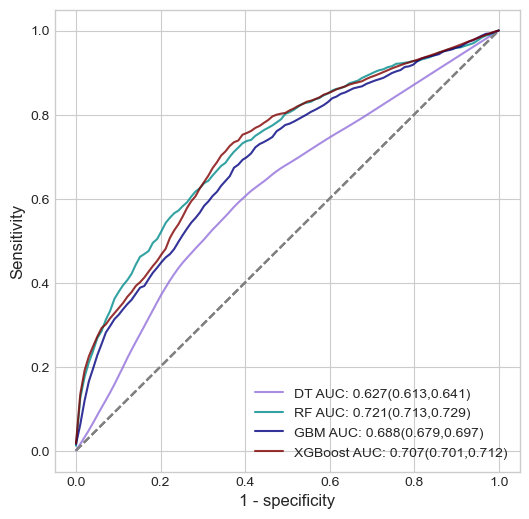

In [335]:
## 复合结局
names = ["DT","RF","GBM","XGBoost"]
include_feature_lists = [outcome_dt_feature[0:5],outcome_rf_feature,outcome_gbm_feature[0:15],outcome_xgb_feature[0:15]]
features_out = ["outcome","outcome","outcome","outcome"]
models = [dt1,rf1,gbm1,xgb1]
colors = ["mediumpurple","darkcyan","navy","maroon"]
results = ["0.627(0.613,0.641)","0.721(0.713,0.729)","0.688(0.679,0.697)","0.707(0.701,0.712)"]
multi_models_roc_curve(names,include_feature_lists,features_out,models,colors,results,save=True)

<module 'matplotlib.pyplot' from '/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

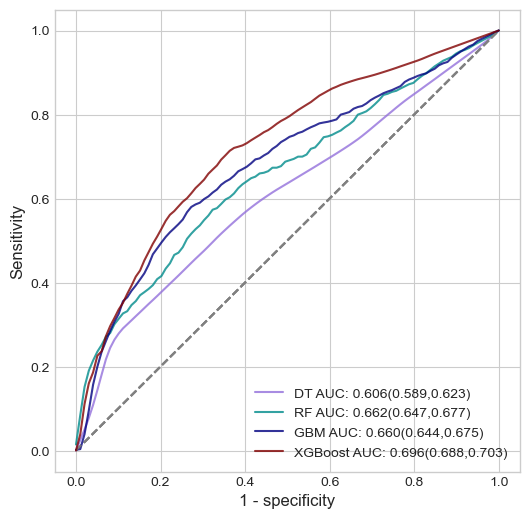

In [337]:
## 心包积液
names = ["DT","RF","GBM","XGBoost"]
include_feature_lists = [outcome_h_dt_feature[0:5],outcome_h_rf_feature[0:5],outcome_h_gbm_feature[0:15],outcome_h_xgb_feature[0:5]]
features_out = ["outcome_h","outcome_h","outcome_h","outcome_h"]
models = [dt2,rf2,gbm2,xgb2]
colors = ["mediumpurple","darkcyan","navy","maroon"]
results = ["0.606(0.589,0.623)","0.662(0.647,0.677)","0.660(0.644,0.675)","0.696(0.688,0.703)"]
multi_models_roc_curve(names,include_feature_lists,features_out,models,colors,results,save=True)

<module 'matplotlib.pyplot' from '/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

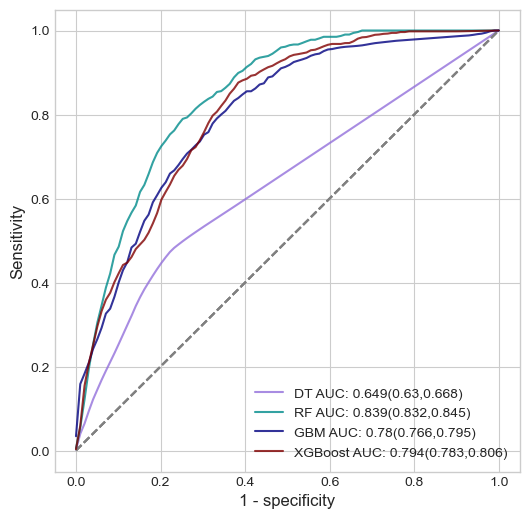

In [338]:
## 出血
names = ["DT","RF","GBM","XGBoost"]
include_feature_lists = [outcome_b_dt_feature[0:5],outcome_b_rf_feature[0:15],outcome_b_gbm_feature[0:15],outcome_b_xgb_feature[0:10]]
features_out = ["outcome_b","outcome_b","outcome_b","outcome_b"]
models = [dt3,rf3,gbm3,xgb3]
colors = ["mediumpurple","darkcyan","navy","maroon"]
results = ["0.649(0.63,0.668)","0.839(0.832,0.845)","0.78(0.766,0.795)","0.794(0.783,0.806)"]
multi_models_roc_curve(names,include_feature_lists,features_out,models,colors,results,save=True)

In [ ]:
## 复合结局
# plt.figure(figsize=(6,6))
# k_fold_cv_roc_curve(outcome_rf_feature,"outcome",rf1)

In [339]:
import sys

In [340]:
print(sys.version)

3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
